In [1]:
from bitcoinrpc.authproxy import AuthServiceProxy, JSONRPCException
import sqlite3
import pandas as pd

In [2]:
rpc_connection = AuthServiceProxy("http://%s:%s@127.0.0.1:8332"%("moises", "moises123"),timeout=100000)
#num_blocks = rpc_connection.getblockcount()
#num_blocks

In [3]:
chunk_size = 1000
#chunks = int(num_blocks/chunk_size)
#chunks

In [4]:
# Pega os primeiros dados da blockchain do bitcoin e envia para uma base de dados sql
# Preciso rodar esses códigos novamente para concertar a falta de valores multiplos de 1000
def initial_load():
    with sqlite3.connect('bitcoin_blockchain.db') as conn:
        for c in range(0,chunks+1):
            block_stats = [rpc_connection.getblockstats(i) for i in range(c*chunk_size+1, (c+1)*chunk_size)+1]
            df = pd.DataFrame(block_stats)
            df['feerate_percentiles'] = df['feerate_percentiles'].astype(str)
            df.to_sql('blockchain', conn, if_exists='append') 
        print(f'finished {(c+1)*chunk_size} record')

def update_chain(start_block):
    num_blocks = rpc_connection.getblockcount()
    block_stas = [rpc_connection.getblockstats(i) for i in range(start_block, num_blocks)]
    df = pd.DataFrame(block_stas)
    df["feerate_percentiles"] = df["feerate_percentiles"].astype(str)
    df.to_sql("blockchain",conn, if_exists='append')

In [5]:
#initial_load() Só precisa fazer uma vez

In [6]:
#update_chain(801000) Atualizar depois 

In [7]:
conn = sqlite3.connect("bitcoin_blockchain.db")
df = pd.read_sql("select * from blockchain", conn)

In [8]:
df.shape[0]
df["height"][100000]

100101

In [9]:
#Util apenas para encontrar o erro do pq o index está diferente do hight do bloco.
"""for index, sub in enumerate(df["subsidy"]):
    if index%1000 == 0:
        user_input = input("Continuar? (s/n): ")
        if user_input== "n":
            break
    print(index, sub) 
"""

'for index, sub in enumerate(df["subsidy"]):\n    if index%1000 == 0:\n        user_input = input("Continuar? (s/n): ")\n        if user_input== "n":\n            break\n    print(index, sub) \n'

In [10]:
# Convertendo os dados de hora de unix time para GMT
df["GMT"] = pd.to_datetime(df["time"], unit="s")
df["GMT"].head()

0   2009-01-09 02:54:25
1   2009-01-09 02:55:44
2   2009-01-09 03:02:53
3   2009-01-09 03:16:28
4   2009-01-09 03:23:48
Name: GMT, dtype: datetime64[ns]

In [11]:
# Criação da coluna de subsidio em btc (transformando satoshi em btc)
df["reward"] = df["subsidy"]/10**(8)

In [12]:
df["reward"]

0         50.00
1         50.00
2         50.00
3         50.00
4         50.00
          ...  
800194     6.25
800195     6.25
800196     6.25
800197     6.25
800198     6.25
Name: reward, Length: 800199, dtype: float64

In [13]:
df["total_supply"] = df["reward"].cumsum()

In [14]:
df["total_supply"]

0               50.00
1              100.00
2              150.00
3              200.00
4              250.00
             ...     
800194    19424281.25
800195    19424287.50
800196    19424293.75
800197    19424300.00
800198    19424306.25
Name: total_supply, Length: 800199, dtype: float64

In [15]:
df.columns

Index(['index', 'avgfee', 'avgfeerate', 'avgtxsize', 'blockhash',
       'feerate_percentiles', 'height', 'ins', 'maxfee', 'maxfeerate',
       'maxtxsize', 'medianfee', 'mediantime', 'mediantxsize', 'minfee',
       'minfeerate', 'mintxsize', 'outs', 'subsidy', 'swtotal_size',
       'swtotal_weight', 'swtxs', 'time', 'total_out', 'total_size',
       'total_weight', 'totalfee', 'txs', 'utxo_increase', 'utxo_size_inc',
       'utxo_increase_actual', 'utxo_size_inc_actual', 'GMT', 'reward',
       'total_supply'],
      dtype='object')

In [16]:
df["year"] = df["GMT"].dt.year
df["year"]

0         2009
1         2009
2         2009
3         2009
4         2009
          ... 
800194    2023
800195    2023
800196    2023
800197    2023
800198    2023
Name: year, Length: 800199, dtype: int32

In [17]:
df.loc[df.year==2010, "reward"].sum()

3392600.0

In [18]:
for i in df["year"].unique():
    print(i)

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [19]:
reward = {i: df.loc[df.year == i, "reward"].sum() for i in df.year.unique()}

reward

{2009: 1622850.0,
 2010: 3392600.0,
 2011: 2978350.0,
 2012: 2609650.0,
 2013: 1584250.0,
 2014: 1470150.0,
 2015: 1356650.0,
 2016: 1044825.0,
 2017: 698412.5,
 2018: 680537.5,
 2019: 677225.0,
 2020: 452868.75,
 2021: 328956.25,
 2022: 332093.75,
 2023: 194887.5}

In [20]:
keys = []
values = []
for i in range(2009,2023):
    keys.append(i)
    values.append(reward[i])


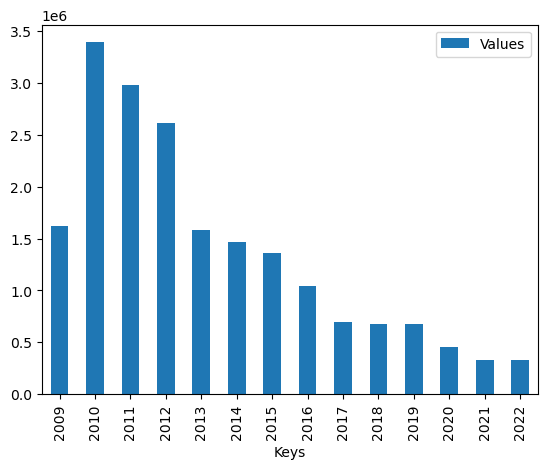

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Example keys and values

# Create a dictionary from keys and values
data_dict = {'Keys': keys, 'Values': values}

# Create a DataFrame from the dictionary
data = pd.DataFrame(data_dict)

# Plot the DataFrame
data.plot(x = "Keys", y = "Values", kind = "bar")
plt.show()


In [22]:
for i in df.year.unique():
    df.loc[df["year"]==i, "annual_flow"] = reward[i] 

In [23]:
df["annual_flow"]

0         1622850.0
1         1622850.0
2         1622850.0
3         1622850.0
4         1622850.0
            ...    
800194     194887.5
800195     194887.5
800196     194887.5
800197     194887.5
800198     194887.5
Name: annual_flow, Length: 800199, dtype: float64

In [24]:
df["sf_ratio"]= df["total_supply"]/df["annual_flow"]

In [25]:
df["GMT_date"] =df["GMT"].dt.date 

In [26]:
df.GMT_date

0         2009-01-09
1         2009-01-09
2         2009-01-09
3         2009-01-09
4         2009-01-09
             ...    
800194    2023-07-31
800195    2023-07-31
800196    2023-07-31
800197    2023-07-31
800198    2023-07-31
Name: GMT_date, Length: 800199, dtype: object

In [27]:
df_daily = df.groupby("GMT_date", as_index = False).agg({"GMT_date":"first", "sf_ratio":"max", "total_supply":"max"})

In [28]:
df_daily

,GMT_date,sf_ratio,total_supply
0,2009-01-09,0.000431,700.00
1,2009-01-10,0.002311,3750.00
2,2009-01-11,0.005176,8400.00
3,2009-01-12,0.008072,13100.00
4,2009-01-13,0.011862,19250.00
...,...,...,...
5312,2023-07-27,99.654897,19421493.75
5313,2023-07-28,99.659387,19422368.75
5314,2023-07-29,99.663620,19423193.75
5315,2023-07-30,99.669008,19424243.75


In [29]:
import calendar
import datetime as dt

In [30]:
calendar.monthrange(2023,6)

(3, 30)

In [31]:
dates = []
for y in df['year'].unique():
    for m in range(1,13):
        dates.append(dt.datetime(y,m,calendar.monthrange(y,m)[1]).date())

In [32]:
dates

[datetime.date(2009, 1, 31),
 datetime.date(2009, 2, 28),
 datetime.date(2009, 3, 31),
 datetime.date(2009, 4, 30),
 datetime.date(2009, 5, 31),
 datetime.date(2009, 6, 30),
 datetime.date(2009, 7, 31),
 datetime.date(2009, 8, 31),
 datetime.date(2009, 9, 30),
 datetime.date(2009, 10, 31),
 datetime.date(2009, 11, 30),
 datetime.date(2009, 12, 31),
 datetime.date(2010, 1, 31),
 datetime.date(2010, 2, 28),
 datetime.date(2010, 3, 31),
 datetime.date(2010, 4, 30),
 datetime.date(2010, 5, 31),
 datetime.date(2010, 6, 30),
 datetime.date(2010, 7, 31),
 datetime.date(2010, 8, 31),
 datetime.date(2010, 9, 30),
 datetime.date(2010, 10, 31),
 datetime.date(2010, 11, 30),
 datetime.date(2010, 12, 31),
 datetime.date(2011, 1, 31),
 datetime.date(2011, 2, 28),
 datetime.date(2011, 3, 31),
 datetime.date(2011, 4, 30),
 datetime.date(2011, 5, 31),
 datetime.date(2011, 6, 30),
 datetime.date(2011, 7, 31),
 datetime.date(2011, 8, 31),
 datetime.date(2011, 9, 30),
 datetime.date(2011, 10, 31),
 dateti

In [33]:
final_df = df.loc[df['GMT_date'].isin(dates)]

# Historical Bitcoin Price and Market Cap 

In [34]:
import investpy
data = investpy.get_crypto_historical_data(crypto="bitcoin", from_date="01/01/2009", to_date="31/07/2023")

ConnectionError: ERR#0015: error 403, try again later.

In [ ]:
import investpy

data = investpy.get_crypto_historical_data(crypto='bitcoin',
                                           from_date='01/01/2014',
                                           to_date='01/01/2019')

print(data.head())

ConnectionError: ERR#0015: error 403, try again later.

In [ ]:
import yfinance as yf

yf.download(tickers="BTC-USD", interval="4h", start= '1 Jan 2018', end=None) f

In [ ]:
import yfinance as yf

btc_data = yf.download("BTC-USD", start="2022-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
btc_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859
...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
